In [1]:
# 2. Importar las librerías necesarias
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor, Compose, Resize
import matplotlib.pyplot as plt
from transformers import CLIPModel, CLIPProcessor

/home/diego/anaconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified


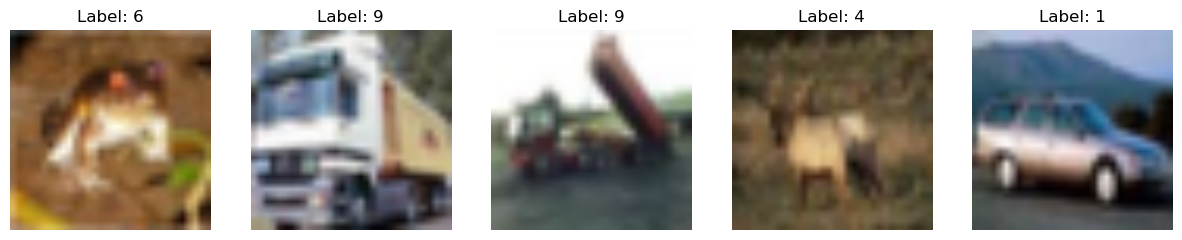

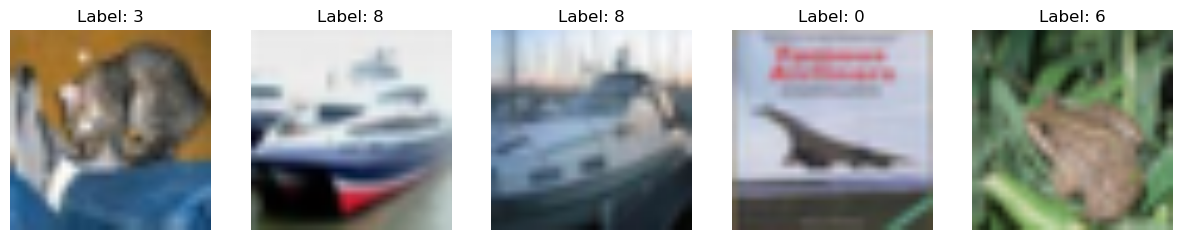

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


Epoch [1/10], Loss: 2.2858
Accuracy of the network on the test images: 16.36%
Epoch [2/10], Loss: 2.2197
Accuracy of the network on the test images: 16.72%
Epoch [3/10], Loss: 2.1834
Accuracy of the network on the test images: 18.90%
Epoch [4/10], Loss: 2.1416
Accuracy of the network on the test images: 20.97%
Epoch [5/10], Loss: 2.0887
Accuracy of the network on the test images: 22.37%
Epoch [6/10], Loss: 2.0454
Accuracy of the network on the test images: 23.86%
Epoch [7/10], Loss: 2.0081
Accuracy of the network on the test images: 23.73%


KeyboardInterrupt: 

In [2]:
# 3. Definir el dispositivo (GPU si está disponible)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 4. Cargar el modelo preentrenado CLIP y moverlo al dispositivo
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

# 5. Congelar los parámetros del modelo CLIP
for param in model.parameters():
    param.requires_grad = False

# 6. Definir las transformaciones para el dataset
transform = Compose([
    Resize((224, 224)),  # Redimensiona las imágenes a 224x224 píxeles
    ToTensor(),
])

# 7. Cargar el dataset CIFAR-10
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

# 8. Definir los DataLoaders para entrenamiento y prueba
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 9. Visualizar ejemplos del dataset
def show_images(dataset, num_images):
    fig, axs = plt.subplots(1, num_images, figsize=(15, 15))
    for i in range(num_images):
        image, label = dataset[i]
        axs[i].imshow(image.permute(1, 2, 0))
        axs[i].set_title(f'Label: {label}')
        axs[i].axis('off')
    plt.show()

show_images(train_dataset, 5)  # Muestra 5 imágenes del conjunto de entrenamiento
show_images(test_dataset, 5)   # Muestra 5 imágenes del conjunto de prueba

# 10. Definir la red neuronal simple
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x

classifier = SimpleClassifier(input_dim=512, hidden_dim=256, output_dim=10).to(device)  # CIFAR-10 tiene 10 clases

# 11. Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)

# 12. Ciclo de entrenamiento
num_epochs = 10  # Ajusta el número de épocas según sea necesario

for epoch in range(num_epochs):
    classifier.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()

        # Procesa las imágenes con el processor de CLIP
        inputs = processor(images=images, return_tensors="pt")
        pixel_values = inputs['pixel_values'].to(device)  # Mueve los tensores al dispositivo

        with torch.no_grad():
            image_embeddings = model.get_image_features(pixel_values).to(device)

        outputs = classifier(image_embeddings)
        loss = criterion(outputs, labels.to(device))  # Mueve las etiquetas al dispositivo
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

    # Evaluación en el conjunto de prueba
    classifier.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            inputs = processor(images=images, return_tensors="pt")
            pixel_values = inputs['pixel_values'].to(device)  # Mueve los tensores al dispositivo
            image_embeddings = model.get_image_features(pixel_values).to(device)
            outputs = classifier(image_embeddings)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()  # Mueve las etiquetas al dispositivo

    print(f'Accuracy of the network on the test images: {100 * correct / total:.2f}%')

# 13. Imprimir el número total de parámetros en CLIP
total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters in CLIP: {total_params}')
